# Learning curve calculation and plotting.
## Author: Zhi Li
## Date: 11/10/2019
### After removing fixed ratio data points, we now have 4967 reactions to model. Based on the overal data, PUFK_SVM model performs the best. In this script, I will accomplish below task for Methylammonium, Ethylammonium, n-Butylammonium,  Formamidinium, Acetamidinium, Cyclohexylmethylammonium (with all 4 metrics) : 1) PUFK_SVM learning curve with N-1 amine 2) PUFK_SVM learning curve with only target amine 3) 1NN learning curve with only target amine 4) single feature (formic acid, organic, inorganic) learning curve with only target amine.
### I fixed learn_rate == 1 end point bug (target amine and N-1 amine with same learning curve end point)
### I fixed N-1 learning curves: in version 3, N-1 learning curves only used 3 concentrations as features.

In [1]:
import os, fnmatch
import numpy as np
import pandas as pd
import pprint
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Data input
file = "0042.perovskitedata_RAPID.csv"
df_all = pd.read_csv(file)
df = pd.DataFrame(columns = df_all.columns)

Inchi = pd.read_csv("Organic Inchikey.csv")
Inchidict = dict(zip(Inchi['Chemical Name'], Inchi['InChI Key (ID)']))

lst = ["LLWRXQXPJMPHLR-UHFFFAOYSA-N","XFYICZOIWSBQSK-UHFFFAOYSA-N","CALQKRVFTWDYDG-UHFFFAOYSA-N",\
       "QHJPGANWSLEMTI-UHFFFAOYSA-N","GGYGJCFIYJVWIP-UHFFFAOYSA-N","FCTHQYIDLRRROX-UHFFFAOYSA-N",\
       "JMXLWMIFDJCGBV-UHFFFAOYSA-N","PXWSKGXEHZHFJA-UHFFFAOYSA-N","DMFMZFFIQRMJQZ-UHFFFAOYSA-N",\
       "NOHLSFNWSBZSBW-UHFFFAOYSA-N","NLJDBTZLVTWXRG-UHFFFAOYSA-N","LCTUISCIGMWMAT-UHFFFAOYSA-N",\
       "WGYRINYTHSORGH-UHFFFAOYSA-N","VAWHFUNJDMQUSB-UHFFFAOYSA-N","HBPSMMXRESDUSG-UHFFFAOYSA-N",\
       "VNAAUNTYIONOHR-UHFFFAOYSA-N","ZEVRFFCPALTVDN-UHFFFAOYSA-N","NXRUEVJQMBGVAT-UHFFFAOYSA-N",\
       "JERSPYRKVMAEJY-UHFFFAOYSA-N"]
for x in lst:
    df = df.append(df_all[(df_all._rxn_organic_inchikey == x)])

In [5]:
Amine_done = [] # actually it is amine for analysis
for i in df['_rxn_organic_inchikey']:
    if i not in Amine_done: 
        Amine_done.append(i)

for i in range(len(Amine_done)):
    Amine_done[i] = dict(zip(Inchi['InChI Key (ID)'],Inchi['Chemical Name']))[Amine_done[i]]
print (Amine_done)

['Methylammonium iodide', 'Ethylammonium Iodide', 'n-Butylammonium iodide', 'Formamidinium Iodide', 'Acetamidinium iodide', 'iso-Butylammonium iodide', 'Dimethylammonium iodide', 'n-Dodecylammonium iodide', 'Pyrrolidinium Iodide', '4-Fluoro-Phenethylammonium iodide', 't-Butylammonium Iodide', '4-Fluoro-Benzylammonium iodide', 'Cyclohexylammonium iodide', 'Morpholinium Iodide', 'Piperidinium Iodide', 'n-Hexylammonium iodide', 'Cyclohexylmethylammonium iodide', 'N,N-Diethylpropane-1,3-diammonium iodide', 'N,N-dimethylpropane- 1,3-diammonium iodide']


In [6]:
# Generate input, output and reference dataframe
X = df.drop(['RunID_vial', '_out_crystalscore', '_rxn_organic_inchikey'], axis =1)
y = df.filter(['_out_crystalscore'], axis =1)
inchikey = df.filter(['RunID_vial', '_rxn_organic_inchikey'])

# Standarize the input
x = StandardScaler().fit_transform(X) # dataframe turned into array and it is reformed as dataframe in the below line
X = pd.DataFrame(x, index = X.index, columns = X.columns)

y = (y.replace([1,2,3],0)).replace(4,1) # turned into binary classification

### Function to calculate lmetric of models

In [250]:
def SVM_PUFK_metrics (X_train,y_train,X_test,y_test, pos_label=1, feature = '_rxn_M_acid'):
    
    def PearsonVII_kernel(X1,X2, sigma=1.0, omega=1.0):
        if X1 is X2 :
            kernel = squareform(pdist(X1, 'euclidean'))
        else:
            kernel = cdist(X1, X2, 'euclidean')
        kernel = (1 + (kernel * 4 * np.sqrt(2**(1.0/omega)-1)) / sigma**2) ** omega
        kernel = 1/kernel
        return kernel
    
    clf = SVC(C=10,cache_size=6000,max_iter=-1,kernel=PearsonVII_kernel,\
              decision_function_shape='ovr', probability=False, class_weight='balanced')
    X_train = X_train.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    X_test = X_test.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    accuracy = clf.score(X_test,y_test)
    precision = precision_score(y_test,y_predict, pos_label=pos_label) 
    recall = recall_score(y_test,y_predict, pos_label=pos_label)
    f1 = f1_score (y_test,y_predict, pos_label=pos_label) 
    return {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [249]:
def SVM_PUFK_metrics_fullfeature (X_train,y_train,X_test,y_test, pos_label=1, feature = '_rxn_M_acid'):
    
    def PearsonVII_kernel(X1,X2, sigma=1.0, omega=1.0):
        if X1 is X2 :
            kernel = squareform(pdist(X1, 'euclidean'))
        else:
            kernel = cdist(X1, X2, 'euclidean')
        kernel = (1 + (kernel * 4 * np.sqrt(2**(1.0/omega)-1)) / sigma**2) ** omega
        kernel = 1/kernel
        return kernel
    
    clf = SVC(C=10,cache_size=6000,max_iter=-1,kernel=PearsonVII_kernel,\
              decision_function_shape='ovr', probability=False, class_weight='balanced')
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    accuracy = clf.score(X_test,y_test)
    precision = precision_score(y_test,y_predict, pos_label=pos_label) 
    recall = recall_score(y_test,y_predict, pos_label=pos_label)
    f1 = f1_score (y_test,y_predict, pos_label=pos_label) 
    return {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [8]:
def KNN_metrics (X_train,y_train,X_test,y_test, pos_label=1, feature = '_rxn_M_acid'):
    clf = KNeighborsClassifier(n_neighbors = 1, weights = "uniform", p = 2)
    X_train = X_train.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    X_test = X_test.filter(['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic'], axis = 1)
    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    accuracy = clf.score(X_test,y_test)
    precision = precision_score(y_test,y_predict, pos_label=pos_label) 
    recall = recall_score(y_test,y_predict, pos_label=pos_label)
    f1 = f1_score (y_test,y_predict, pos_label=pos_label) 
    return {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [9]:
# Human prediction: based on the feacture with highest priority
def onefeaturekNN (X_train,y_train,X_test,y_test, pos_label=1, feature = '_rxn_M_acid', k=1):
    clf = KNeighborsClassifier(n_neighbors = k, weights = "uniform", p = 2)
    X_train = X_train.filter([feature], axis = 1)
    X_test = X_test.filter([feature], axis = 1)
    clf.fit(X_train,y_train)   
    y_predict = clf.predict(X_test)
    accuracy = clf.score(X_test,y_test)                       
    precision = precision_score(y_test,y_predict, pos_label=pos_label)                      
    recall = recall_score(y_test,y_predict, pos_label=pos_label)                  
    f1 = f1_score(y_test,y_predict, pos_label=pos_label)
    return {'accuracy': accuracy, 'precision':precision, 'recall':recall, 'f1':f1}

In [10]:
def train_size (X_ammonium_train, node):
    n = len(X_ammonium_train[0].index)
    split = list(map(lambda x: int(x*n), node))
    return split

In [11]:
# Function to save any obj in 'obj' folder
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as file:
        pickle.dump(obj, file, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as file:
        return pickle.load(file)

### Function to calculate learning metric

In [251]:
def learn_score (learn_rate, n_splits,\
                 X_ammonium_train, y_ammonium_train, X_ammonium_test, y_ammonium_test,\
                 X_rest_ammonium = 0, y_rest_ammonium = 0,\
                 f = SVM_PUFK_metrics, metric = 'accuracy', feature = '_rxn_M_acid', rest_ammonium = 0):
    learn_metric = np.zeros((len(learn_rate), n_splits, n_splits))
    for j in range(len(learn_rate)):
        if (learn_rate[j]>0) & (learn_rate[j]<1):
            for i in range(n_splits):               
                score_list = []
                learn_split = StratifiedShuffleSplit(n_splits=n_splits , test_size=1-learn_rate[j], random_state=42)
                for train_index, test_index in learn_split.split(X_ammonium_train[i], y_ammonium_train[i]):
                    if rest_ammonium == 0:
                        score_list.append(f(X_ammonium_train[i].iloc[train_index], y_ammonium_train[i].iloc[train_index],\
                                            X_ammonium_test[i], y_ammonium_test[i], feature = feature)[metric])
                    elif rest_ammonium == 1:
                        score_list.append(f(pd.concat([X_ammonium_train[i].iloc[train_index], X_rest_ammonium]),\
                                            pd.concat([y_ammonium_train[i].iloc[train_index], y_rest_ammonium]),\
                                            X_ammonium_test[i], y_ammonium_test[i])[metric])#stop here
                learn_metric[j][i] = score_list
                print('finished train/test split number: ', (i+1))
        elif learn_rate[j] == 1:
            for i in range(n_splits):
                if rest_ammonium == 0:
                    learn_metric[j][i] = [f(X_ammonium_train[i],y_ammonium_train[i],\
                                            X_ammonium_test[i], y_ammonium_test[i], feature = feature)[metric]]*n_splits
                elif rest_ammonium == 1:
                    learn_metric[j][i] = [f(pd.concat([X_ammonium_train[i], X_rest_ammonium]),\
                                            pd.concat([y_ammonium_train[i], y_rest_ammonium]),\
                                            X_ammonium_test[i], y_ammonium_test[i], feature = feature)[metric]]*n_splits
                print('finished train/test split number: ', (i+1))
        else:
            raise IndexError()
        print('finished learning rate: ', learn_rate[j])
        
    if rest_ammonium == 1:
        learn_0 = np.zeros((n_splits, n_splits))
        for i in range(n_splits):
            learn_0[i] = [f(X_rest_ammonium, y_rest_ammonium, X_ammonium_test[i], y_ammonium_test[i])[metric]]*n_splits
        learn_metric = np.insert(learn_metric, obj = [0], values = learn_0, axis = 0)
        print('Added prediction metric with only N-1 ammonium')
    return learn_metric

### Fuction to plot learning curve for different metrics

In [14]:
def learn_plot (learn_1, learn_2, learn_3, learn_4, learn_5, \
                X_ammonium_train, learn_rate, percentage_0_test, \
                name, metrics_list = ['accuracy', 'precision', 'recall', 'f1'], ymin = 0, ymax = 1):
    
    #building x axis (# of trainingsets in target ammonium)
    x_axis = train_size (X_ammonium_train, node = learn_rate)
    y_axis_1_mean = {}
    y_axis_1_std = {}
    y_axis_2_mean = {}
    y_axis_2_std = {}
    y_axis_3_mean = {}
    y_axis_3_std = {}
    y_axis_4_mean = {}
    y_axis_4_std = {}
    y_axis_5_mean = {}
    y_axis_5_std = {}
    
    #Calculation of mean and std for metric curves
    for metric in metrics_list:
        y_axis_1_mean[metric] = []
        y_axis_1_std[metric] = []
        y_axis_2_mean[metric] = []
        y_axis_2_std[metric] = []
        y_axis_3_mean[metric] = []
        y_axis_3_std[metric] = []
        y_axis_4_mean[metric] = []
        y_axis_4_std[metric] = []
        y_axis_5_mean[metric] = []
        y_axis_5_std[metric] = []
        
        for i in range(len(learn_rate)):
            y_axis_1_mean[metric].append(np.mean(learn_1[metric][i].flatten()))
            y_axis_1_std[metric].append(np.std(learn_1[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_2_mean[metric].append(np.mean(learn_2[metric][i].flatten()))
            y_axis_2_std[metric].append(np.std(learn_2[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_3_mean[metric].append(np.mean(learn_3[metric][i].flatten()))
            y_axis_3_std[metric].append(np.std(learn_3[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_4_mean[metric].append(np.mean(learn_4[metric][i].flatten()))
            y_axis_4_std[metric].append(np.std(learn_4[metric][i].flatten()))
        for i in range(len(learn_rate)):
            y_axis_5_mean[metric].append(np.mean(learn_5[metric][i].flatten()))
            y_axis_5_std[metric].append(np.std(learn_5[metric][i].flatten()))
        
    # Metrics for random guess
    y_axis_monotone = {'accuracy': [max(percentage_0_test, (1-percentage_0_test))]*(len(learn_rate)), \
                       'precision': [(1-percentage_0_test)]*(len(learn_rate)), \
                       'recall': [1]*(len(learn_rate)), \
                       'f1':[(2*(1-percentage_0_test)/(1+(1-percentage_0_test)))]*(len(learn_rate))}
    
    # Plotting
    for metric in metrics_list:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x_axis, y_axis_1_mean[metric], 'o-', color = "r", label = "PUFK-SVM prediction")
        ax.plot(x_axis, y_axis_2_mean[metric], '^-', color = "green", label = "Formic acid based prediction")
        ax.plot(x_axis, y_axis_3_mean[metric], 's-', color = "blue", label = "Inorganic based prediction")
        ax.plot(x_axis, y_axis_4_mean[metric], 'd-', color = "purple", label = "Organic based prediction")
        ax.plot(x_axis, y_axis_5_mean[metric], 'H-', color='black', label = "kNN prediction")
        ax.plot(x_axis, y_axis_monotone[metric], color = 'black', label = "Majority voting" if metric == 'accuracy' else 'All positive voting', linestyle='dashed')
        

        ax.fill_between (x_axis, np.array(y_axis_1_mean[metric]) - np.array(y_axis_1_std[metric]), \
                         np.array(y_axis_1_mean[metric]) + np.array(y_axis_1_std[metric]), \
                         color="r", alpha = 0.2)
        ax.fill_between (x_axis, np.array(y_axis_5_mean[metric]) - np.array(y_axis_5_std[metric]), \
                         np.array(y_axis_5_mean[metric]) + np.array(y_axis_5_std[metric]), \
                         color="gray", alpha = 0.2)
        ax.fill_between (x_axis, np.array(y_axis_2_mean[metric]) - np.array(y_axis_2_std[metric]), \
                         np.array(y_axis_2_mean[metric]) + np.array(y_axis_2_std[metric]), \
                         color="green", alpha = 0.2)
        ax.fill_between (x_axis, np.array(y_axis_3_mean[metric]) - np.array(y_axis_3_std[metric]), \
                         np.array(y_axis_3_mean[metric]) + np.array(y_axis_3_std[metric]), \
                         color="blue", alpha = 0.1)
        ax.fill_between (x_axis, np.array(y_axis_4_mean[metric]) - np.array(y_axis_4_std[metric]), \
                         np.array(y_axis_4_mean[metric]) + np.array(y_axis_4_std[metric]), \
                         color="purple", alpha = 0.1)\

        
        ax.set_ylim(ymin, ymax)
        ax.legend()          
        ax.set_xlabel('Number of training experiments')
        ax.set_ylabel('Prediction ' + metric)
        ax.set_title('SVM prediction on ' + name)
        plt.savefig('Learning_Curves/Model comparison on '+ name + '_' + metric + '.svg', format = 'svg', transparent=True)

### User input parameters start here

In [105]:
# Train-test splitting options
n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits , test_size=0.2, random_state=42)

# Learning rate/step for different model metrics
learn_rate_1 = [0.1,0.33,0.55,0.78,1.0]
learn_rate_2 = [0.02,0.06,0.1,0.2,0.33,0.55,0.78,1.0]
learn_rate_3 = [0.2,0.4,0.6,0.8,1.0]

metrics_list = ['accuracy', 'precision', 'recall', 'f1']
feature_list = ['_rxn_M_acid', '_rxn_M_inorganic', '_rxn_M_organic']

In [106]:
amine_dict = {'Methylammonium iodide':'MAPbI3','Ethylammonium Iodide':'EtAPbI3', 'n-Butylammonium iodide':'nBuA2PbI4',\
               'Formamidinium Iodide':'FAPbI3', 'Acetamidinium iodide':'AcetPbI3', \
              'Cyclohexylmethylammonium iodide': 'CHMA2PbI4'}

## Learning curve generation

In [171]:
Amine_done

['Methylammonium iodide',
 'Ethylammonium Iodide',
 'n-Butylammonium iodide',
 'Formamidinium Iodide',
 'Acetamidinium iodide',
 'iso-Butylammonium iodide',
 'Dimethylammonium iodide',
 'n-Dodecylammonium iodide',
 'Pyrrolidinium Iodide',
 '4-Fluoro-Phenethylammonium iodide',
 't-Butylammonium Iodide',
 '4-Fluoro-Benzylammonium iodide',
 'Cyclohexylammonium iodide',
 'Morpholinium Iodide',
 'Piperidinium Iodide',
 'n-Hexylammonium iodide',
 'Cyclohexylmethylammonium iodide',
 'N,N-Diethylpropane-1,3-diammonium iodide',
 'N,N-dimethylpropane- 1,3-diammonium iodide']

In [572]:
ammonium = 'N,N-dimethylpropane- 1,3-diammonium iodide'

##Split "unknown" amine and "known" amine

# Find ammonium index in original dataframe
inchi = Inchidict[ammonium]
ammonium_index = inchikey.index[inchikey['_rxn_organic_inchikey'] == inchi].tolist()

# pick target ammonium
X_ammonium = X.filter(ammonium_index, axis = 0)
y_ammonium = y.filter(ammonium_index, axis = 0)

# pick N-1 ammonium
X_rest_ammonium = X.drop(ammonium_index, axis = 0)
y_rest_ammonium = y.drop(ammonium_index, axis = 0)


## Split trainsets and testsets
# Generate train and test list, number of elements (dataframe) is n_splits in Train-test splitting options
X_ammonium_train = []
y_ammonium_train = []
X_ammonium_test = []
y_ammonium_test = []

for train_index, test_index in sss.split(X_ammonium, y_ammonium):
    X_ammonium_train.append(X_ammonium.iloc[train_index])
    y_ammonium_train.append(y_ammonium.iloc[train_index])
    X_ammonium_test.append(X_ammonium.iloc[test_index])
    y_ammonium_test.append(y_ammonium.iloc[test_index])

print(train_size(X_ammonium_train, (learn_rate_1)))

# percentage of 0 and 1 in y_ammonium_test
percentage_0_test = list(y_ammonium_test[0]['_out_crystalscore']).count(0)\
    /len(y_ammonium_test[0].index)
print (percentage_0_test)

[7, 25, 41, 59, 76]
0.85


In [573]:
percentage_0_test
count_1 = y_ammonium[y_ammonium['_out_crystalscore']==1]
count_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 2494 to 2570
Data columns (total 1 columns):
_out_crystalscore    16 non-null int64
dtypes: int64(1)
memory usage: 256.0 bytes


### Single feature prediction learning curve generation,  one feature nearest neighbor score

In [125]:
for feature in feature_list:
    learn_ammonium_only_1feature = {}
    for metric in metrics_list:
        learn_ammonium_only_1feature[metric] = learn_score (learn_rate = learn_rate_1, n_splits=n_splits,\
                                                             X_ammonium_train = X_ammonium_train,\
                                                             y_ammonium_train = y_ammonium_train,\
                                                             X_ammonium_test = X_ammonium_test,\
                                                             y_ammonium_test = y_ammonium_test,\
                                                             X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                                             f = onefeaturekNN, feature = feature, metric = metric, rest_ammonium = 0)
        print('finished predicion metric: ', metric)
    print('finished predicion feature: ', feature)
    save_obj(learn_ammonium_only_1feature, 'learn_ammonium_only_1feature_' + ammonium + feature)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
finished predicion feature:  _rxn_M_inorganic
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split nu

### SVM learning curve generation

In [261]:
# With only targe amine
learn_ammonium_only = {}
for metric in metrics_list:
    learn_ammonium_only[metric] = learn_score (learn_rate = learn_rate_3, n_splits=n_splits,\
                                               X_ammonium_train = X_ammonium_train, \
                                               y_ammonium_train = y_ammonium_train,\
                                               X_ammonium_test = X_ammonium_test, \
                                               y_ammonium_test = y_ammonium_test,\
                                               X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                               f = SVM_PUFK_metrics, feature = feature, metric = metric, rest_ammonium = 0)
    print('finished predicion metric: ', metric)
save_obj(learn_ammonium_only, 'learn_ammonium_only_PUFKSVM_3D_' + ammonium)

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.4
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.6
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:

In [260]:
# With N-1 + target amine
learn_ammonium_rest = {}
for metric in metrics_list:
    learn_ammonium_rest[metric] = learn_score (learn_rate = learn_rate_3, n_splits=n_splits,\
                                               X_ammonium_train = X_ammonium_train, \
                                               y_ammonium_train = y_ammonium_train,\
                                               X_ammonium_test = X_ammonium_test, \
                                               y_ammonium_test = y_ammonium_test,\
                                               X_rest_ammonium = X_rest_ammonium, y_rest_ammonium = y_rest_ammonium,\
                                               f = SVM_PUFK_metrics_fullfeature, feature = feature, metric = metric, rest_ammonium = 1)
    print('finished predicion metric: ', metric)
save_obj(learn_ammonium_rest, 'learn_ammonium_rest_PUFKSVM_' + ammonium)

finished train/test split number:  1


KeyboardInterrupt: 

### kNN learning curve generation

In [128]:
learn_ammonium_only_kNN = {}
for metric in metrics_list:
    learn_ammonium_only_kNN[metric] = learn_score (learn_rate = learn_rate_1, n_splits=n_splits,\
                                                   X_ammonium_train = X_ammonium_train, \
                                                   y_ammonium_train = y_ammonium_train,\
                                                   X_ammonium_test = X_ammonium_test, \
                                                   y_ammonium_test = y_ammonium_test,\
                                                   X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                                   f = KNN_metrics, feature = feature, metric = metric, rest_ammonium = 0)
    print('finished predicion metric: ', metric)
save_obj(learn_ammonium_only_kNN, 'learn_ammonium_only_kNN_3D_' + ammonium)

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
f

## Learning curve generation (loop out all 19 ammoniums)

In [254]:
Amine_done

['Methylammonium iodide',
 'Ethylammonium Iodide',
 'n-Butylammonium iodide',
 'Formamidinium Iodide',
 'Acetamidinium iodide',
 'iso-Butylammonium iodide',
 'Dimethylammonium iodide',
 'n-Dodecylammonium iodide',
 'Pyrrolidinium Iodide',
 '4-Fluoro-Phenethylammonium iodide',
 't-Butylammonium Iodide',
 '4-Fluoro-Benzylammonium iodide',
 'Cyclohexylammonium iodide',
 'Morpholinium Iodide',
 'Piperidinium Iodide',
 'n-Hexylammonium iodide',
 'Cyclohexylmethylammonium iodide',
 'N,N-Diethylpropane-1,3-diammonium iodide',
 'N,N-dimethylpropane- 1,3-diammonium iodide']

In [264]:
for ammonium in Amine_done:
    
    ##Split "unknown" amine and "known" amine
    # Find ammonium index in original dataframe
    inchi = Inchidict[ammonium]
    ammonium_index = inchikey.index[inchikey['_rxn_organic_inchikey'] == inchi].tolist()
    
    if ammonium == 'Ethylammonium Iodide':
        learn_rate_loop = learn_rate_2
    elif (ammonium == 'Piperidinium Iodide') or (ammonium =='N,N-Diethylpropane-1,3-diammonium iodide'):
        learn_rate_loop = learn_rate_3   
    else:
        learn_rate_loop = learn_rate_1
    

    # pick target ammonium
    X_ammonium = X.filter(ammonium_index, axis = 0)
    y_ammonium = y.filter(ammonium_index, axis = 0)

    # pick N-1 ammonium
    X_rest_ammonium = X.drop(ammonium_index, axis = 0)
    y_rest_ammonium = y.drop(ammonium_index, axis = 0)


    ## Split trainsets and testsets
    # Generate train and test list, number of elements (dataframe) is n_splits in Train-test splitting options
    X_ammonium_train = []
    y_ammonium_train = []
    X_ammonium_test = []
    y_ammonium_test = []

    for train_index, test_index in sss.split(X_ammonium, y_ammonium):
        X_ammonium_train.append(X_ammonium.iloc[train_index])
        y_ammonium_train.append(y_ammonium.iloc[train_index])
        X_ammonium_test.append(X_ammonium.iloc[test_index])
        y_ammonium_test.append(y_ammonium.iloc[test_index])

    print('Start' + ammonium)
    print('Learning rate is')
    print(train_size(X_ammonium_train, (learn_rate_loop)))
    print('************************************************')
    
    print('Start single feature')
    ## Single feature prediction learning curve generation,  one feature nearest neighbor score
    for feature in feature_list:
        learn_ammonium_only_1feature = {}
        for metric in metrics_list:
            learn_ammonium_only_1feature[metric] = learn_score (learn_rate = learn_rate_loop, n_splits=n_splits,\
                                                                 X_ammonium_train = X_ammonium_train,\
                                                                 y_ammonium_train = y_ammonium_train,\
                                                                 X_ammonium_test = X_ammonium_test,\
                                                                 y_ammonium_test = y_ammonium_test,\
                                                                 X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                                                 f = onefeaturekNN, feature = feature, metric = metric, rest_ammonium = 0)
            print('finished predicion metric: ', metric)
        print('finished predicion feature: ', feature)
        save_obj(learn_ammonium_only_1feature, 'learn_ammonium_only_1feature_' + ammonium + feature)
    
    print('Start kNN 3D')
    ## kNN learning curve generation
    learn_ammonium_only_kNN = {}
    for metric in metrics_list:
        learn_ammonium_only_kNN[metric] = learn_score (learn_rate = learn_rate_loop, n_splits=n_splits,\
                                                       X_ammonium_train = X_ammonium_train, \
                                                       y_ammonium_train = y_ammonium_train,\
                                                       X_ammonium_test = X_ammonium_test, \
                                                       y_ammonium_test = y_ammonium_test,\
                                                       X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                                       f = KNN_metrics, feature = feature, metric = metric, rest_ammonium = 0)
        print('finished predicion metric: ', metric)
    save_obj(learn_ammonium_only_kNN, 'learn_ammonium_only_kNN_3D_' + ammonium)
    
    ## SVM learning curve generation
    
    print('SVM only target amine')
    # With only target amine
    learn_ammonium_only = {}
    for metric in metrics_list:
        learn_ammonium_only[metric] = learn_score (learn_rate = learn_rate_loop, n_splits=n_splits,\
                                                   X_ammonium_train = X_ammonium_train, \
                                                   y_ammonium_train = y_ammonium_train,\
                                                   X_ammonium_test = X_ammonium_test, \
                                                   y_ammonium_test = y_ammonium_test,\
                                                   X_rest_ammonium = 0, y_rest_ammonium = 0,\
                                                   f = SVM_PUFK_metrics, feature = feature, metric = metric, rest_ammonium = 0)
        print('finished predicion metric: ', metric)
    save_obj(learn_ammonium_only, 'learn_ammonium_only_PUFKSVM_3D_' + ammonium)
    
    print('SVM N-1 amine')
    # With N-1 + target amine
    learn_ammonium_rest = {}
    for metric in metrics_list:
        learn_ammonium_rest[metric] = learn_score (learn_rate = learn_rate_loop, n_splits=n_splits,\
                                                   X_ammonium_train = X_ammonium_train, \
                                                   y_ammonium_train = y_ammonium_train,\
                                                   X_ammonium_test = X_ammonium_test, \
                                                   y_ammonium_test = y_ammonium_test,\
                                                   X_rest_ammonium = X_rest_ammonium, y_rest_ammonium = y_rest_ammonium,\
                                                   f = SVM_PUFK_metrics_fullfeature, feature = feature, metric = metric, rest_ammonium = 1)
        print('finished predicion metric: ', metric)
    save_obj(learn_ammonium_rest, 'learn_ammonium_rest_PUFKSVM_' + ammonium)
    


StartMethylammonium iodide
Learning rate is
[12, 40, 67, 95, 123]
************************************************
Start single feature
finished train/test split number:  1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
finished predicion feature:  _rxn_M_inorganic
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split nu

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
f

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
SVM N-1 amine
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test spl

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.02
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.06
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split num

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
fin

finished train/test split number:  5
finished learning rate:  0.02
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.06
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
f

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
SVM only target amine
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.02
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.06
finished train/test split number:  1
finished train/test split number:  2
finished train

finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
A

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33


finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
f

finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
f

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  f1
StartFormamidinium Iodide
Learning rate is
[17, 56, 94, 134, 172]
************************************************
Start single feature
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number

finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
finished predicion feature:  _rxn_M_inorgani

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
fin

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test 

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split numbe

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
SVM N-1 amine
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:

finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
finished predicion feature:  _rxn_M_acid
fin

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
fin

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split num

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split numbe

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  f1
Startn-Dodecylammonium iodide
Learning rate is
[11, 37, 63, 89, 115]
************************************************
Start single feature
finished train/test split number:  

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
fin

finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  precision
finished train/test split number:  1
finished train/test

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split numbe

finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
f

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
SVM N-1 amine
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split numb

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split numbe

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
f

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  f1
Start4-Fluoro-Benzylammonium iodide
Learning rate is
[7, 25, 41, 59, 76]
************************************************
Start single feature
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test spli

finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test 

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numbe

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
finished predicion feature:  _rxn_M_acid
fin

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.4
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.6
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  precision
fin

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.6
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.4
fini

finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.4
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.6
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
fini

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.6
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  f1
Startn-Hexylammonium iodide
Learning rate is
[7, 25, 41, 59, 76]
************************************************
Start single feature
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number: 

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:

finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
fin

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test 

finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
f

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split numb

finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
SVM N-1 amine
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test spl

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.4
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.4
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.6
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.6
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.8
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  precision
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.2
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  accuracy
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numbe

finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split numb

finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.55
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
finished predicion metric:  f1
SVM only target amine
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/

finished train/test split number:  5
finished learning rate:  0.78
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  1.0
Added prediction metric with only N-1 ammonium
finished predicion metric:  recall
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.1
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:  0.33
finished train/test split number:  1
finished train/test split number:  2
finished train/test split number:  3
finished train/test split number:  4
finished train/test split number:  5
finished learning rate:

###    

## Plotting

In [265]:
learn_rate_list

{'Methylammonium iodide': [12, 40, 67, 95, 123],
 'Ethylammonium Iodide': [27, 81, 135, 270, 446, 744, 1056, 1354],
 'n-Butylammonium iodide': [26, 86, 144, 204, 262],
 'Formamidinium Iodide': [17, 56, 94, 134, 172],
 'Acetamidinium iodide': [56, 184, 308, 436, 560],
 'iso-Butylammonium iodide': [19, 63, 105, 149, 192],
 'Dimethylammonium iodide': [23, 76, 127, 180, 232],
 'n-Dodecylammonium iodide': [11, 37, 63, 89, 115],
 'Pyrrolidinium Iodide': [15, 50, 84, 119, 153],
 '4-Fluoro-Phenethylammonium iodide': [11, 37, 63, 89, 115],
 't-Butylammonium Iodide': [7, 25, 41, 59, 76],
 '4-Fluoro-Benzylammonium iodide': [7, 25, 41, 59, 76],
 'Cyclohexylammonium iodide': [7, 25, 41, 59, 76],
 'Morpholinium Iodide': [7, 25, 41, 59, 76],
 'Piperidinium Iodide': [15, 30, 45, 60, 76],
 'n-Hexylammonium iodide': [7, 25, 41, 59, 76],
 'Cyclohexylmethylammonium iodide': [7, 25, 41, 59, 76],
 'N,N-Diethylpropane-1,3-diammonium iodide': [15, 30, 45, 60, 76],
 'N,N-dimethylpropane- 1,3-diammonium iodide'

In [387]:
amine_dict = {'Methylammonium iodide': 'MAPbI3','Ethylammonium Iodide': 'EtAPbI3','n-Butylammonium iodide': 'nBuA2PbI4',\
              'Formamidinium Iodide': 'FAPbI3','Acetamidinium iodide': 'AcetPbI3','Cyclohexylmethylammonium iodide': 'CHMA2PbI4',\
             'iso-Butylammonium iodide': 'iBuA2PbI4','Dimethylammonium iodide': 'DiMAPbI3', 'n-Dodecylammonium iodide': 'nDodA2PbI4',\
             'Pyrrolidinium Iodide': 'PyrroPbI3', '4-Fluoro-Phenethylammonium iodide': '4FPhenEtAPbI3', 't-Butylammonium Iodide': 'tBuA2PbI4',\
             '4-Fluoro-Benzylammonium iodide':'4FBenAPbI3', 'Cyclohexylammonium iodide': 'CHA2PbI4', 'Morpholinium Iodide':'MorphPbI3',\
             'Piperidinium Iodide': 'PiperPbI3', 'n-Hexylammonium iodide':'nHexPbI3','Cyclohexylmethylammonium iodide':'CHMAPbI3',\
             'N,N-Diethylpropane-1,3-diammonium iodide': 'NNDiEtPAPbI3', 'N,N-dimethylpropane- 1,3-diammonium iodide':'NNDiMPAPbI3'}

In [388]:
amine_dict

{'Methylammonium iodide': 'MAPbI3',
 'Ethylammonium Iodide': 'EtAPbI3',
 'n-Butylammonium iodide': 'nBuA2PbI4',
 'Formamidinium Iodide': 'FAPbI3',
 'Acetamidinium iodide': 'AcetPbI3',
 'Cyclohexylmethylammonium iodide': 'CHMAPbI3',
 'iso-Butylammonium iodide': 'iBuA2PbI4',
 'Dimethylammonium iodide': 'DiMAPbI3',
 'n-Dodecylammonium iodide': 'nDodA2PbI4',
 'Pyrrolidinium Iodide': 'PyrroPbI3',
 '4-Fluoro-Phenethylammonium iodide': '4FPhenEtAPbI3',
 't-Butylammonium Iodide': 'tBuA2PbI4',
 '4-Fluoro-Benzylammonium iodide': '4FBenAPbI3',
 'Cyclohexylammonium iodide': 'CHA2PbI4',
 'Morpholinium Iodide': 'MorphPbI3',
 'Piperidinium Iodide': 'PiperPbI3',
 'n-Hexylammonium iodide': 'nHexPbI3',
 'N,N-Diethylpropane-1,3-diammonium iodide': 'NNDiEtPAPbI3',
 'N,N-dimethylpropane- 1,3-diammonium iodide': 'NNDiMPAPbI3'}

#### Plotting Learning Curves for each amine (kNN, onefeaturekNN, SVM)

[7, 25, 41, 59, 76]


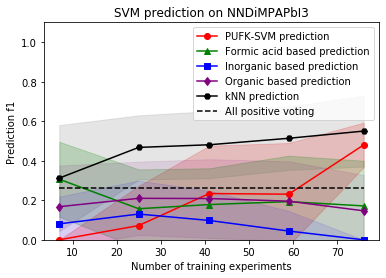

In [580]:
learn_svm = load_obj('learn_ammonium_only_PUFKSVM_3D_' + ammonium)
learn_svm_rest = load_obj('learn_ammonium_rest_PUFKSVM_' + ammonium)
learn_kNN = load_obj('learn_ammonium_only_kNN_3D_' + ammonium)
learn_acid = load_obj('learn_ammonium_only_1feature_' + ammonium + '_rxn_M_acid')
learn_inorganic = load_obj('learn_ammonium_only_1feature_' + ammonium + '_rxn_M_inorganic')
learn_organic = load_obj('learn_ammonium_only_1feature_' + ammonium + '_rxn_M_organic')

['accuracy', 'precision', 'recall', 'f1']

print (learn_rate_list[ammonium])

learn_plot (learn_1 = learn_svm, learn_2 = learn_acid, learn_3 = learn_inorganic, \
            learn_4 = learn_organic, learn_5 = learn_kNN,\
            X_ammonium_train = X_ammonium_train, learn_rate = learn_rate_1, \
            percentage_0_test = percentage_0_test, \
            name = amine_dict[ammonium], metrics_list = ['f1'], ymin = 0.0, ymax = 1.1)

#### N-1 vs 1 prediction comparison

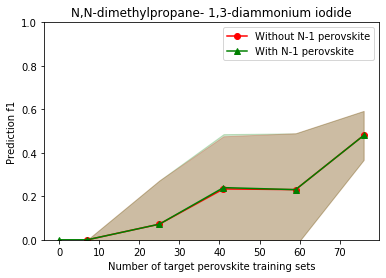

In [585]:
['accuracy', 'precision', 'recall', 'f1']

metric = 'f1' # the metric we would like to look at

#building x axis (# of trainingsets in target ammonium)
x_axis = learn_rate_list[ammonium]
x_axis_0 = x_axis.copy()
x_axis_0.insert(0,0)

fig = plt.figure()
ax = fig.add_subplot(111)

y_axis_mean_only = []
y_axis_std_only = []
y_axis_mean_rest = []
y_axis_std_rest = []

for i in range(len(x_axis)):
    y_axis_mean_only.append(np.mean(learn_svm[metric][i].flatten()))
    y_axis_std_only.append(np.std(learn_svm[metric][i].flatten()))
for i in range(len(x_axis)+1):
    y_axis_mean_rest.append(np.mean(learn_svm_rest[metric][i].flatten()))
    y_axis_std_rest.append(np.std(learn_svm_rest[metric][i].flatten()))
        
# Plotting
ax.plot (x_axis, y_axis_mean_only, marker = 'o', color = 'red', label = 'Without N-1 perovskite')
ax.plot (x_axis_0, y_axis_mean_rest, marker = '^', color = 'green', label = 'With N-1 perovskite')
ax.fill_between (x_axis, np.array(y_axis_mean_only) - np.array(y_axis_std_only), \
                        np.array(y_axis_mean_only) + np.array(y_axis_std_only), \
                        color = 'red', alpha = 0.2)
ax.fill_between (x_axis_0, np.array(y_axis_mean_rest) - np.array(y_axis_std_rest), \
                        np.array(y_axis_mean_rest) + np.array(y_axis_std_rest), \
                        color = 'green', alpha = 0.2)

ax.set_ylim(0.0,1.0)
ax.legend()          
ax.set_xlabel('Number of target perovskite training sets')
ax.set_ylabel('Prediction ' + metric)
ax.set_title(ammonium)
plt.savefig('Learning_Curves/N vs 1' + '_' + ammonium + '_' + metric + '.svg', format = 'svg', transparent=True)

#### Accuracy prediction for all 6 perovskites

In [154]:
learn_rate_list

{'Methylammonium iodide': [12, 40, 67, 95, 123],
 'Ethylammonium Iodide': [27, 81, 135, 270, 446, 744, 1056, 1354],
 'n-Butylammonium iodide': [26, 86, 144, 204, 262],
 'Formamidinium Iodide': [17, 56, 94, 134, 172],
 'Acetamidinium iodide': [56, 184, 308, 436, 560],
 'iso-Butylammonium iodide': [19, 63, 105, 149, 192],
 'Dimethylammonium iodide': [23, 76, 127, 180, 232],
 'n-Dodecylammonium iodide': [11, 37, 63, 89, 115],
 'Pyrrolidinium Iodide': [15, 50, 84, 119, 153],
 '4-Fluoro-Phenethylammonium iodide': [11, 37, 63, 89, 115],
 't-Butylammonium Iodide': [7, 25, 41, 59, 76],
 '4-Fluoro-Benzylammonium iodide': [7, 25, 41, 59, 76],
 'Cyclohexylammonium iodide': [7, 25, 41, 59, 76],
 'Morpholinium Iodide': [7, 25, 41, 59, 76],
 'Piperidinium Iodide': [15, 30, 45, 60, 76],
 'n-Hexylammonium iodide': [7, 25, 41, 59, 76],
 'Cyclohexylmethylammonium iodide': [7, 25, 41, 59, 76],
 'N,N-Diethylpropane-1,3-diammonium iodide': [15, 30, 45, 60, 76],
 'N,N-dimethylpropane- 1,3-diammonium iodide'

In [155]:
amine_dict

{'Methylammonium iodide': 'MAPbI3',
 'Ethylammonium Iodide': 'EtAPbI3',
 'n-Butylammonium iodide': 'nBuA2PbI4',
 'Formamidinium Iodide': 'FAPbI3',
 'Acetamidinium iodide': 'AcetPbI3',
 'Cyclohexylmethylammonium iodide': 'CHMA2PbI4'}

In [266]:
learn_svm_list = {}
for key,value in amine_dict.items(): 
    learn_svm_list[value] = load_obj('learn_ammonium_only_PUFKSVM_3D_' + key)

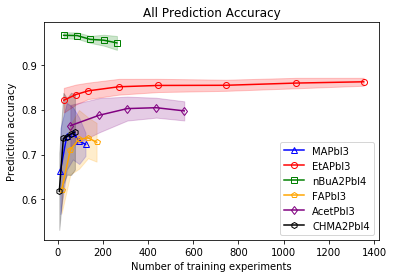

In [590]:
# Training data number for learning curve.
x_MA = learn_rate_list['Methylammonium iodide']
x_EtA = learn_rate_list['Ethylammonium Iodide']
x_nBuA = learn_rate_list['n-Butylammonium iodide']
x_FA = learn_rate_list['Formamidinium Iodide']
x_Acet = learn_rate_list['Acetamidinium iodide']
x_CHMA = learn_rate_list['Cyclohexylmethylammonium iodide']

#building x axis (# of trainingsets in target ammonium)
x_axis = [x_MA, x_EtA, x_nBuA, x_FA, x_Acet,x_CHMA]
metric = 'accuracy'
color_type = ['blue', 'red', 'green','orange', 'purple','black']
marker_type = ['^', 'o', 's', 'p', 'd','h']

fig = plt.figure()
ax = fig.add_subplot(111)


for j in range(len(learn_svm_list)):
    y_axis_mean = []
    y_axis_std = []
    if (list(learn_svm_list.keys())[j] == 'EtAPbI3'):
        learn_rate_plot = learn_rate_2
    elif (list(learn_svm_list.keys())[j] == 'PiperPbI3') or (list(learn_svm_list.keys())[j] =='NNDiEtPAPbI3'):
        learn_rate_plot = learn_rate_3   
    else:
        learn_rate_plot = learn_rate_1
        
    for i in range(len(learn_rate_plot)):
        y_axis_mean.append(np.mean(learn_svm_list[list(learn_svm_list.keys())[j]][metric][i].flatten()))
        y_axis_std.append(np.std(learn_svm_list[list(learn_svm_list.keys())[j]][metric][i].flatten()))
        
    # Plotting
    ax.plot (x_axis[j], y_axis_mean, marker = marker_type[j], markerfacecolor = 'None', color = color_type[j], label = list(learn_svm_list.keys())[j])
    ax.fill_between (x_axis[j], np.array(y_axis_mean) - np.array(y_axis_std), \
                         np.array(y_axis_mean) + np.array(y_axis_std), \
                         color = color_type[j], alpha = 0.2)

    #ax.set_xlim(0, len(X_ammonium.index))
    ax.legend()          
    ax.set_xlabel('Number of training experiments')
    ax.set_ylabel('Prediction ' + metric)
    ax.set_title('All Prediction Accuracy')
plt.savefig('Learning_Curves/PUFK_SVM_Prediction_all 6 perovskite' + '_' + metric + '.svg', format = 'svg', transparent=True)

## Code not used

In [ ]:
np.mean(learn_svm_list['EtAPbI3']['accuracy'][3].flatten())

In [ ]:
learn_kNN_EtA = load_obj('learn_ammonium_only_kNN_3D_' + 'Ethylammonium Iodide')

In [ ]:
np.mean((learn_kNN_EtA['accuracy'][2]).flatten())

In [ ]:
np.mean((learn_kNN_EtA['accuracy'][3]).flatten())

In [134]:
learn_rate_list = {}

for ammonium in Amine_done:
    
    if ammonium == "Ethylammonium Iodide":
        learn_rate = learn_rate_2
    elif ammonium == "Piperidinium Iodide":
        learn_rate = learn_rate_3
    elif ammonium == "N,N-Diethylpropane-1,3-diammonium iodide":
        learn_rate = learn_rate_3
    else:
        learn_rate = learn_rate_1

    ##Split "unknown" amine and "known" amine

    # Find ammonium index in original dataframe
    inchi = Inchidict[ammonium]
    ammonium_index = inchikey.index[inchikey['_rxn_organic_inchikey'] == inchi].tolist()

    # pick target ammonium
    X_ammonium = X.filter(ammonium_index, axis = 0)
    y_ammonium = y.filter(ammonium_index, axis = 0)

    # pick N-1 ammonium
    X_rest_ammonium = X.drop(ammonium_index, axis = 0)
    y_rest_ammonium = y.drop(ammonium_index, axis = 0)


    ## Split trainsets and testsets
    # Generate train and test list, number of elements (dataframe) is n_splits in Train-test splitting options
    X_ammonium_train = []
    y_ammonium_train = []
    X_ammonium_test = []
    y_ammonium_test = []

    for train_index, test_index in sss.split(X_ammonium, y_ammonium):
        X_ammonium_train.append(X_ammonium.iloc[train_index])
        y_ammonium_train.append(y_ammonium.iloc[train_index])
        X_ammonium_test.append(X_ammonium.iloc[test_index])
        y_ammonium_test.append(y_ammonium.iloc[test_index])

    print(train_size(X_ammonium_train, (learn_rate)))
    learn_rate_list[ammonium] = train_size(X_ammonium_train, (learn_rate))

    # percentage of 0 and 1 in y_ammonium_test
    percentage_0_test = list(y_ammonium_test[0]['_out_crystalscore']).count(0)\
        /len(y_ammonium_test[0].index)
    
save_obj(learn_rate_list, 'learn_rate_list')

[12, 40, 67, 95, 123]
[27, 81, 135, 270, 446, 744, 1056, 1354]
[26, 86, 144, 204, 262]
[17, 56, 94, 134, 172]
[56, 184, 308, 436, 560]
[19, 63, 105, 149, 192]
[23, 76, 127, 180, 232]
[11, 37, 63, 89, 115]
[15, 50, 84, 119, 153]
[11, 37, 63, 89, 115]
[7, 25, 41, 59, 76]
[7, 25, 41, 59, 76]
[7, 25, 41, 59, 76]
[7, 25, 41, 59, 76]
[15, 30, 45, 60, 76]
[7, 25, 41, 59, 76]
[7, 25, 41, 59, 76]
[15, 30, 45, 60, 76]
[7, 25, 41, 59, 76]
